In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
import cv2
from os.path import abspath
from os.path import join as p_join
from pathlib import Path 
import os
import scipy
import librosa
import librosa.display

import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['image.cmap'] = 'gray'
data_fpath = p_join(abspath(''), 'data')
print(data_fpath)

C:\Users\Theresa\Documents\CS_Master\EPFL\CM\Project\AudioImagers\data


In [2]:
# we will need some real-world audio for some examples. 
from IPython.display import Audio
from scipy.io import wavfile

# Brandenburg concerto #1, mono, 8 kHz
audio_sample_sf, audio_sample = wavfile.read(p_join(data_fpath, "brand1.wav"))
audio_sample = audio_sample / 32767.0
print("duration:", len(audio_sample), "sample rate:", audio_sample_sf, "length=", len(audio_sample)/audio_sample_sf)
Audio(audio_sample, rate=audio_sample_sf)

duration: 63923 sample rate: 8000 length= 7.990375


functions for transforming image 

In [3]:
import scipy.interpolate as interpolate
from scipy import optimize


def sharpen_from_kernel_center(center, im):
    # creates a sharpening kernel with the given center magnitude that defines the degree of sharpening/blurring
    other = -(center-1)/8
    kernel = np.array([[other,other,other], [other,center,other], [other,other,other]])
    img = cv2.filter2D(im, -1, kernel)
    return img


def change_laplacian(image_path, target_value, plot=False):
    """
    reads image, manipulates sharpness and writes again to temporary file
    """
    # do not change if target is 0 bc then the feature is not relevant
    if target_value == 0:
        return
    # read the (temporary) image that is to be manipulated
    im = cv2.imread(image_path)

    # calculate the current laplacian value
    lap = cv2.Laplacian(im, -1, ksize=1)
    before = lap.var()

    # the amount of change in the laplacian depends on the kernel magnitude (-> the value at the center of the kernel)
    # we can model the laplacian as a function of this center value.
    # this function is mostly quadratic -> compute sharpness values for a few center values and interpolate with quadratic/cubic function
    # then find the center value that corresponds to the desired sharpness according to the interpolation
    vars = []
    # use 5 values for the interpolation
    interpolation_space = np.linspace(0,5,5)
    for c in interpolation_space:
        # sharpen/blur (center<1?) image with kernel with given center. 
        img = sharpen_from_kernel_center(c, im)
        # compute laplacian of modified image
        v = cv2.Laplacian(img, -1, ksize=1).var()
        vars += [v]
    # interpolate (center, laplacian) pairs
    interp_fn = interpolate.interp1d(interpolation_space,vars,kind='cubic', fill_value='extrapolate')
    # subtract target_value so that the 0 crossing corresponds to the desired value
    interp_fn2 = lambda x: (interp_fn(x)-target_value)


    # if the desired laplacian is not reachable, use the smallest possible
    if target_value <= interp_fn(0):
        center = 0
    # else find the kernel center that comes closest to the desired laplacian by finding 0-crossing
    else :
        center = optimize.newton(interp_fn2, 3, tol=10**(-10))

    # sharpen image with found center
    img = sharpen_from_kernel_center(center, im)

    # write to temp file
    cv2.imwrite(image_path, img)

In [4]:
def change_hsv(image_path, target_values, change_hue=False):
    """
    reads image, manipulates HSV channels and writes back to file
    """
    im = cv2.imread(image_path, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    # current HSV values of image
    HSV = np.mean(np.mean(im, axis = 1), axis=0)
    difference = target_values - HSV

    # we do not always want to modify the hue because the overlapping with RGB is very strong and hue is angular so the mean of hues is not very meaningful
    # we only change the hue if RGB are not changed
    if change_hue:
        start = 0
    else: 
        start = 1

    for i in range(start, 3):
        # do not change if target value is 0 bc then the feature is not relevant
        if target_values[i]==0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(im)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            im = cv2.subtract(im, diff)
        # if positive we need to increase it
        else:
            im = cv2.add(im, diff)
    # write the resulting image back to the file
    im = cv2.cvtColor(im, cv2.COLOR_HSV2BGR)
    cv2.imwrite(image_path, im)
    return im

In [5]:
def change_bgr(image_path, target_values):
    """
    reads image, manipulates bgr channels and writes back to file
    """
    # in BGR format
    im = cv2.imread(image_path)
    
    # current BGR values of image
    RGB = np.mean(np.mean(im, axis = 1), axis=0)
    difference = target_values - RGB
    for i in range(3):
        # do not change if target value is 0 bc that means that the feature is not relevant
        if target_values[i] == 0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(im)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            im = cv2.subtract(im, diff)
        # if positive we need to increase it
        else:
            im = cv2.add(im, diff)
    # write the resulting image back to the file
    cv2.imwrite(image_path, im)
    return im

In [6]:
def transform_image(target_values, image_path):
    # read image and store in temporary file in which we store the changed temporary file after each manipulation step
    # use a temporary file because some functions use cv2 and others PIL, also we do not want to overwrite the original file
    # returns manipulated image
    im = cv2.imread(image_path)
    folder = image_path.rsplit('\\', 1)[0]
    temp_file = p_join(folder, 'temp.jpg')
    cv2.imwrite(temp_file, im)

    # change feature values to mean values of target emotion
    change_bgr(temp_file, target_values[['blue', 'green', 'red']].values[0])
    if np.all(target_values[['blue', 'green', 'red']].values[0]==0):
        change_hsv(temp_file, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=True)
    else:
        change_hsv(temp_file, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=False)

    change_laplacian(temp_file, target_values['sharpness'].values)
    return cv2.imread(temp_file)

Read test image

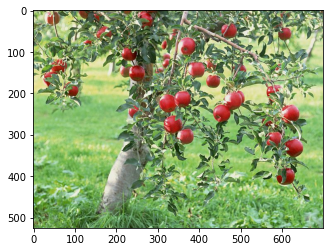

In [7]:
image_path = p_join(data_fpath, "apples.jpg")

im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

transform with random values

mean RGB before [134.59251700680272, 157.93769523809524, 102.53281088435374]
mean RGB after [210.9707782312925, 117.63367346938776, 27.574647619047617]


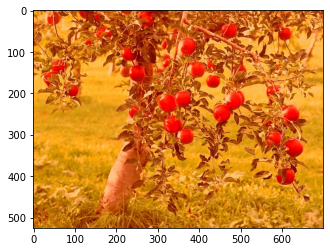

In [9]:
import pandas as pd
target_values = {'hue': 0, 'saturation': 0, 'brightness':0, 'red': 222, 'blue': 10, 'green': 117, 'sharpness': 0}
df = pd.DataFrame()
df = df.append(target_values, ignore_index=True)
temp_path = p_join(data_fpath, "temp.jpg")

im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print("mean RGB before", [np.mean(im[:,:,i]) for i in range(3)])

im = transform_image(df, image_path)
im = cv2.imread(temp_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print("mean RGB after", [np.mean(im[:,:,i]) for i in range(3)])
plt.imshow(im)

example: map change in amplitude to change in RGB values

1. bin frequencies of sample into 3 bins (low, middle, high frequencies)
2. compute the mean amplitude of each bin
3. compute mean RGB values of image
4. ratio of new amplitudes to old amplitudes defines ratio of new RGB to old RGB
5. change image accordingly

repeat over 10 disjoint time samples

initial BGR [102.53281088435374, 157.93769523809524, 134.59251700680272]
old means BGR [102.53281088435374, 157.93769523809524, 134.59251700680272]
new means BGR [240.91184217687075, 246.25582857142857, 139.59300408163264] 

old means BGR [240.91184217687075, 246.25582857142857, 139.59300408163264]
new means BGR [158.0122530612245, 246.642062585034, 252.41732789115648] 

old means BGR [158.0122530612245, 246.642062585034, 252.41732789115648]
new means BGR [200.7348, 217.37977414965985, 179.11464489795918] 

old means BGR [200.7348, 217.37977414965985, 179.11464489795918]
new means BGR [117.85176054421768, 166.57714285714286, 173.33692244897958] 

old means BGR [117.85176054421768, 166.57714285714286, 173.33692244897958]
new means BGR [250.33913197278912, 240.4836925170068, 131.45283265306122] 

old means BGR [250.33913197278912, 240.4836925170068, 131.45283265306122]
new means BGR [163.29726258503402, 225.54959455782313, 188.7338149659864] 

old means BGR [163.29726258503402, 225.54959

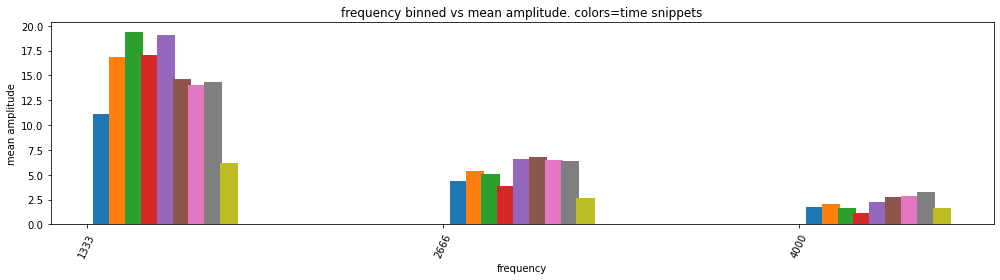

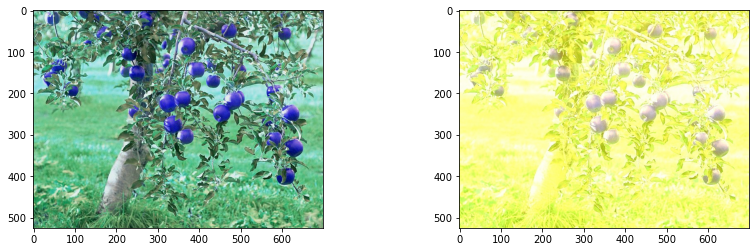

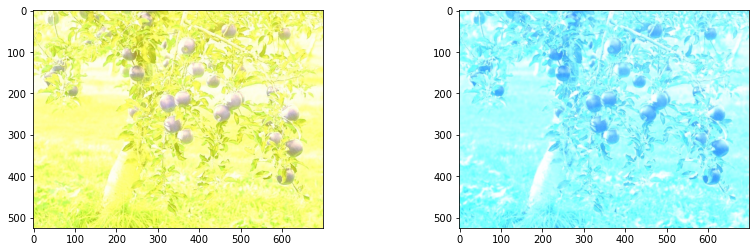

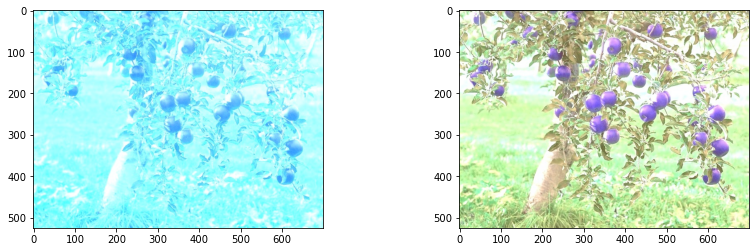

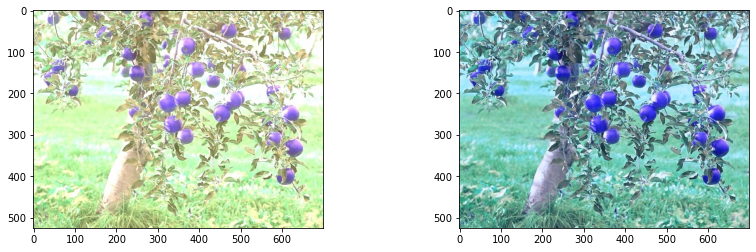

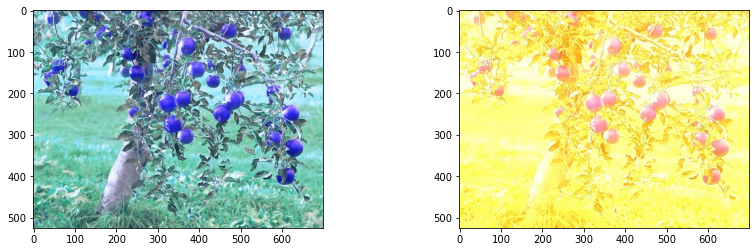

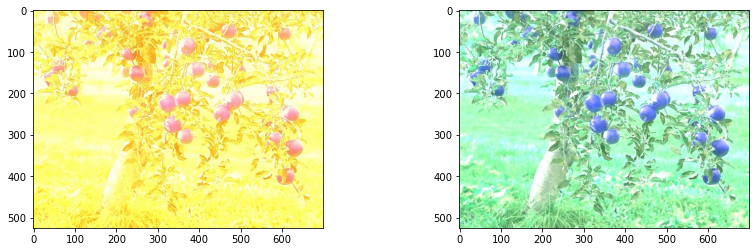

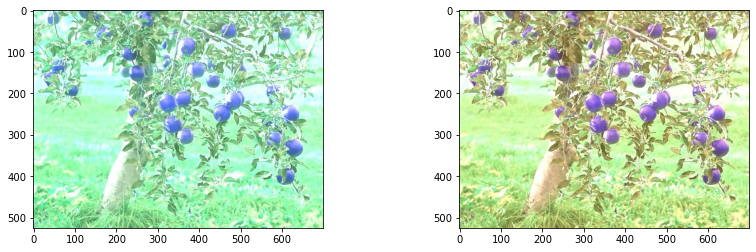

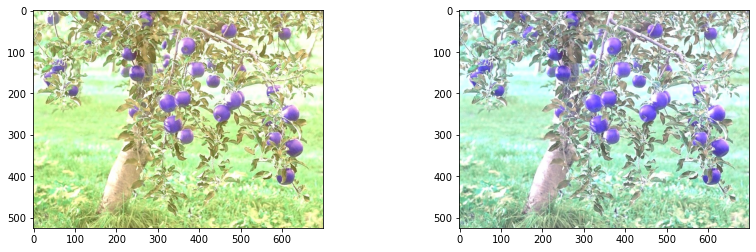

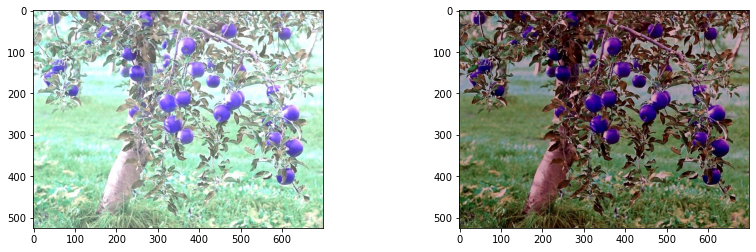

In [12]:
num_time_bins = 10
time_bin_size = int(len(audio_sample)/num_time_bins)
widths = np.linspace(0,num_time_bins*0.04,num_time_bins)
fig,ax = plt.subplots()
fmax = audio_sample_sf / 2

im = cv2.imread(image_path)
print("initial BGR", [np.mean(im[:,:,i]) for i in range(3)])
im_prev = im

# first sample
sample = audio_sample[:time_bin_size]
N = int(len(sample) * fmax / audio_sample_sf)
X = np.abs(np.fft.fft(sample)[0:N])
num_bins = 3
bin_size = int(len(X)/num_bins)
# bin the frequencies into three channels (low, middle, high frequencies) and compute average amplitude for each bin
binned_freq_prev = np.array([np.mean(X[i*bin_size : (i+1)*bin_size]) for i in range(num_bins)])

# loop over samples (make them overlapping?)
for i in range(1,num_time_bins):
    sample = audio_sample[i*time_bin_size:(i+1)*time_bin_size]
    
    # fft
    N = int(len(sample) * fmax / audio_sample_sf)
    X = np.abs(np.fft.fft(sample)[0:N])
    freq = np.linspace(0, fmax, N)
    
    binned_freq_curr = np.array([np.mean(X[i*bin_size : (i+1)*bin_size]) for i in range(num_bins)])
    
    fig2,ax2 = plt.subplots(1,2)
    
    ax.bar(np.arange(num_bins)+widths[i], binned_freq_curr, width=0.051)
    ax.set_xticks(np.arange(num_bins))
    ax.set_xticklabels(((np.arange(1,num_bins+1)/num_bins)*fmax).astype(int), rotation=65)
    
    # modify image accordingly
    # compute RGB values of previous image
    prev_values = np.array([np.mean(im_prev[:,:,i]) for i in range(3)])
    # change according to change in frequency
    new_values = (prev_values * binned_freq_curr)/binned_freq_prev
    
    target_values = {'hue': 0, 'saturation': 0, 'brightness':0, 'red': new_values[0], 'green': new_values[1], 'blue': new_values[2], 'sharpness': 0}
    
    df = pd.DataFrame()
    df = df.append(target_values, ignore_index=True)
    im_new = transform_image(df, image_path)
    old_means = [np.mean(im_prev[:,:,i]) for i in range(3)]
    new_means = [np.mean(im_new[:,:,i]) for i in range(3)]
    
    ax2[0].imshow(im_prev)
    ax2[1].imshow(im_new)
    
    print("old means BGR", [np.mean(im_prev[:,:,i]) for i in range(3)])
    print("new means BGR", [np.mean(im_new[:,:,i]) for i in range(3)], "\n")
    
    binned_freq_prev = binned_freq_curr
    im_prev = im_new
    
ax.set_title("frequency binned vs mean amplitude. colors=time snippets")
ax.set_xlabel("frequency")
ax.set_ylabel("mean amplitude")
fig.tight_layout()
plt.show()